# Collaborative filtering

## Dependencies

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import MiniBatchNMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [101]:
ratings = pd.read_csv("../data/movielens/ratings.csv")

## Preprocessing

In [102]:
ratings = ratings.drop(columns="timestamp")
ratings.head(2)

,user_id,movie_id,rating
0,1,1,4.0
1,1,110,4.0


In [103]:
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_ratings = ratings["rating"].shape[0]

print(f"There are {n_users} users in the dataset.")
print(f"There are {n_movies} movies in the dataset.")
print(f"There are {n_ratings} ratings in the dataset.")

There are 330975 users in the dataset.
There are 83239 movies in the dataset.
There are 33832162 ratings in the dataset.


### Filtering

In [104]:
# Finding stats on user ratings
ratings_per_user = ratings.groupby("user_id").size()
print(f"Average ratings per user: {ratings_per_user.mean():.2f}")
print(f"Median ratings per user: {ratings_per_user.median():.2f}")
print(f"Min ratings: {ratings_per_user.min()}")
print(f"Max ratings: {ratings_per_user.max()}")
print()
mean_user_rating = ratings_per_user.mean()

# Filtering out users with less than the average number of ratings
user_rating_counts = ratings["user_id"].value_counts()
average_users = user_rating_counts[user_rating_counts >= mean_user_rating].index
filtered_ratings = ratings[ratings["user_id"].isin(average_users)]

# Reviewing the filtered dataset
n_users_filtered = filtered_ratings["user_id"].nunique()
print(f"There are now {n_users_filtered} users in the dataset. {n_users_filtered / n_users:.2%} of the original dataset.")

Average ratings per user: 102.22
Median ratings per user: 31.00
Min ratings: 1
Max ratings: 33332

There are now 79469 users in the dataset. 24.01% of the original dataset.


In [105]:
# Finding stats on movie ratings
ratings_per_movie = ratings.groupby("movie_id").size()
print(f"Average ratings per movie: {ratings_per_movie.mean():.2f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.2f}")
print(f"Min ratings: {ratings_per_movie.min()}")
print(f"Max ratings: {ratings_per_movie.max()}")
print()

# Filtering out movies with few ratings
movie_rating_counts = filtered_ratings["movie_id"].value_counts()
average_movies = movie_rating_counts[movie_rating_counts >= 25].index
filtered_ratings = filtered_ratings[filtered_ratings["movie_id"].isin(average_movies)]

# Reviewing the filtered dataset
n_movies_filtered = filtered_ratings["movie_id"].nunique()
print(f"There are now {n_movies_filtered} movies in the dataset. {n_movies_filtered / n_movies:.2%} of the original dataset.")

Average ratings per movie: 406.45
Median ratings per movie: 5.00
Min ratings: 1
Max ratings: 122296

There are now 20821 movies in the dataset. 25.01% of the original dataset.


In [106]:
# Reviewing the number of ratings
n_ratings_filtered = filtered_ratings["rating"].shape[0]
print(f"There are now {n_ratings_filtered} ratings in the dataset. {n_ratings_filtered / n_ratings:.2%} of the original dataset.")

There are now 26167161 ratings in the dataset. 77.34% of the original dataset.


In [107]:
ratings = filtered_ratings

### Scaling user ratings

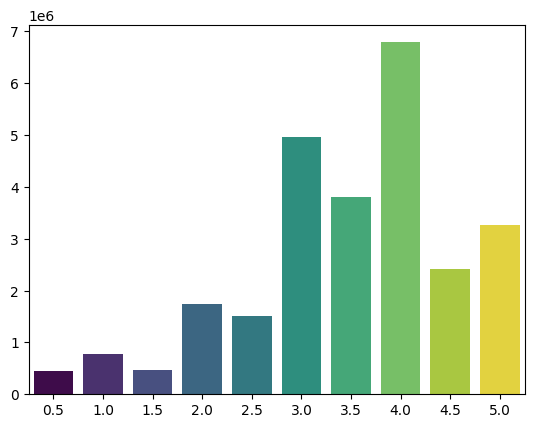

In [108]:
# Visualising the rating distribution
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()), hue=list(rating_distribution.keys()), palette="viridis", legend=False);

In [109]:
def scaler(df):
    """
    Scales (standardising and normalising) the ratings of each user. 
    Standardising is necessary since the ratings overall are not normally distributed 
    and some users might always rate high, low or with a large variance. 
    Normalising is necessary since matrix factorisation can only handle non-negative values.

    Arguments:
    df -- DataFrame with user_id, movie_id and rating columns

    Returns:
    df -- DataFrame with user_id, movie_id and scaled rating columns
    """
    df_collection = []
    for user, user_df in df.groupby("user_id"): 
        rating_values = user_df["rating"].values
        mean = np.mean(rating_values)
        std = np.std(rating_values)
        if std < 1e-10:
            user_df["rating"]=0.5 # if std is 0, set rating to 0.5 which is an average rating once ratings are normalised (0 to 1)
        else:
            std_values = (rating_values - mean) / std
            min_std = np.min(std_values)
            max_std = np.max(std_values)
            user_df["rating"] = (std_values - min_std) / (max_std - min_std)
        df_collection.append(user_df) # stores dataframes in a list which are concatenated at the end
    return pd.concat(df_collection)


scaled_ratings = ratings.copy()
scaled_ratings = scaler(scaled_ratings)

In [110]:
scaled_ratings.head(2)

,user_id,movie_id,rating
304,7,1,0.666667
305,7,3,0.333333


In [111]:
ratings = scaled_ratings

### User-movie matrix

In [112]:
# Creating a user-movie matrix using pivot_table() crashes the kernel. 
# I tried creating a sparse matrix (see line below) with user_id, movie_id and rating as rows, columns and values but that resulted in a much larger matrix than users*movies. 
# sparse_matrix = coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"])))
# From my understanding the issue is that the IDs are not contiguous (0, 1, 2, 3 ...) resulting in a shape of max_user_ID*max_movie_ID.
# I asked Claude Sonnet 3.7 to: "Modify the code to create a sparse matrix in the shape of users*movies."

# Get unique user and movie IDs
unique_users = np.sort(ratings["user_id"].unique())
unique_movies = np.sort(ratings["movie_id"].unique())

# Create mappings from original IDs to consecutive indices
user_mapper = {user: i for i, user in enumerate(unique_users)}
movie_mapper = {movie: i for i, movie in enumerate(unique_movies)}

# Recovering the original user and movie IDs
# user???
# movie???

# Map original IDs to indices
rows = np.array([user_mapper[user] for user in ratings["user_id"]])
cols = np.array([movie_mapper[movie] for movie in ratings["movie_id"]])
vals = ratings["rating"].values

# Create the sparse matrix with appropriate shape
rating_matrix = csr_matrix((vals, (rows, cols)), shape=(len(unique_users), len(unique_movies)))

In [113]:
density = rating_matrix.nnz / (rating_matrix.shape[0] * rating_matrix.shape[1])
print(f"Only {density * 100:.3f} % of the matrix contains ratings.") 

Only 1.581 % of the matrix contains ratings.


In [114]:
rating_matrix.shape

(79469, 20821)

## Matrix factorisation

### Find the optimal rank

In [115]:
rank_range = range(5, 51, 5)
b = 5000
sample = 1000
RMSE_values = []
user_idxs = np.random.choice(rating_matrix.shape[0], sample, replace=False)
item_idxs = np.random.choice(rating_matrix.shape[1], sample, replace=False)

# for n in rank_range:
#     model = MiniBatchNMF(
#         n_components=n,
#         batch_size=b
#     )
#     W = model.fit_transform(rating_matrix)
#     H = model.components_
#     V = np.dot(W[user_idxs, :], H[:, item_idxs])
#     R = rating_matrix[user_idxs, :][:, item_idxs].toarray()
#     RMSE = np.sqrt(mean_squared_error(R, V))
#     RMSE_values.append(RMSE)

model = MiniBatchNMF(
    n_components=400, # 200 tog 10 minuter
    batch_size=b
)
W = model.fit_transform(rating_matrix)
H = model.components_
V = np.dot(W[user_idxs, :], H[:, item_idxs])
R = rating_matrix[user_idxs, :][:, item_idxs].toarray()
RMSE = np.sqrt(mean_squared_error(R, V))
RMSE_values.append(RMSE)

# plt.plot(rank_range, RMSE_values, marker="o")
# plt.xlabel("Rank")
# plt.ylabel("RMSE")
# plt.title("RMSE vs Rank")
# plt.xticks(rank_range)
# plt.grid()
# plt.show()

In [ ]:
RMSE_values # n_comp = 10

[np.float64(0.0770991896006089)]

In [ ]:
RMSE_values # n_comp = 200

[np.float64(0.06537206556613549)]

### Finding the optimal regularisation value

In [ ]:
model = MiniBatchNMF()
params = {
    "alpha_H": [0.01, 0.1, 1],
    "alpha_W": [0.01, 0.1, 1]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
grid_search.fit(V)
print(f"Best parameters: {grid_search.best_params_}")

/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/albotgoodman/coding/repos/machine-learning/.venv/lib/pytho

Best parameters: {'alpha_H': 0.01, 'alpha_W': 0.01}


### MBNMF model

In [ ]:
n = 35
b = 5000
a = 0.01

nmf = MiniBatchNMF(n_components=n, batch_size=b, alpha_W=a, alpha_H=a)
W = nmf.fit_transform(rating_matrix)
H = nmf.components_
print(f"Shape of W: {W.shape}")
print(f"Shape of H: {H.shape}")

Shape of W: (79469, 35)
Shape of H: (35, 20821)


## Movie data

In [24]:
movies = pd.read_csv("../data/movielens/movies.csv")
movies["genres"] = movies["genres"].replace("(no genres listed)", np.nan)
movies["genres"] = movies["genres"].str.lower().str.replace("|", " ").str.replace("-", "").str.strip()
movies["year"] = movies["title"].str.extract(r"\((\d{4})\)")
movies["title"] = movies["title"].str.replace(r"\[.*?\]|\(.*?\)", "", regex=True).str.strip()
movies.dropna(how="any", inplace=True) # dropping 7300 NaN values
movies = movies.drop(columns="genres")

In [25]:
movies.shape

(79237, 3)

In [26]:
movies = movies[movies["movie_id"].isin(ratings["movie_id"].unique())]

In [27]:
movies.shape

(20607, 3)

## Recommendations

In [29]:
def get_movie_index(movie_id):
    # Convert original movie_id to the matrix index
    return movie_mapper.get(movie_id)

In [87]:
def get_similar_movies(movie_id, n_recommendations=10000):
    movie_idx = get_movie_index(movie_id)
    if movie_idx is None:
        return "Movie ID not found"
    
    # Get latent factors for target movie
    target_factors = H[:, movie_idx]
    
    # Calculate similarities - directly comparing latent factors
    similarities = []
    for idx in range(H.shape[1]):
        if idx != movie_idx:
            # sim = np.dot(target_factors, H[:, idx]) # Either dot product
            sim = np.dot(target_factors, H[:, idx]) / (np.linalg.norm(target_factors) * np.linalg.norm(H[:, idx])) # Or cosine similarity 
            similarities.append((idx, sim))
    
    # Sort and get top recommendations
    similarities.sort(key=lambda x: x[1], reverse=True)
    similar_indices = [idx for idx, _ in similarities[:n_recommendations]]
    
    # Map back to original IDs
    return [reverse_movie_mapper[idx] for idx in similar_indices]

In [88]:
# Create reverse mappers to convert indices back to IDs
reverse_movie_mapper = {idx: movie_id for movie_id, idx in movie_mapper.items()}

def get_recommendations(movie_id, n_recommendations=10):
    similar_movie_ids = get_similar_movies(movie_id, n_recommendations)
    
    # Get movie details (title, etc.) from the movies dataframe
    recommendations = movies[movies['movie_id'].isin(similar_movie_ids)]
    return recommendations

In [89]:
budapest_hotel = get_recommendations(109374)
# budapest_hotel = budapest_hotel.drop(columns="movie_id")
budapest_hotel

,movie_id,title,year
11858,55269,"Darjeeling Limited, The",2007
13949,72226,Fantastic Mr. Fox,2009
15676,82459,True Grit,2010
16444,86882,Midnight in Paris,2011
18169,94959,Moonrise Kingdom,2012
18636,97306,Seven Psychopaths,2012
20533,106100,Dallas Buyers Club,2013
21774,112183,Birdman: Or,2014
27216,128360,The Hateful Eight,2015
40306,158238,The Nice Guys,2016


In [116]:
budapest_hotel_400 = get_recommendations(109374)
budapest_hotel_400

,movie_id,title,year
9443,30810,"Life Aquatic with Steve Zissou, The",2004
11858,55269,"Darjeeling Limited, The",2007
13949,72226,Fantastic Mr. Fox,2009
16444,86882,Midnight in Paris,2011
18169,94959,Moonrise Kingdom,2012
19028,99114,Django Unchained,2012
20661,106782,"Wolf of Wall Street, The",2013
21774,112183,Birdman: Or,2014
27216,128360,The Hateful Eight,2015
40306,158238,The Nice Guys,2016


In [90]:
Dogtooth = get_recommendations(77307)
Dogtooth

,movie_id,title,year
16313,86320,Melancholia,2011
18525,96832,Holy Motors,2012
19200,99917,Upstream Color,2013
19369,100556,"Act of Killing, The",2012
19776,102684,Only God Forgives,2013
20832,107649,Borgman,2013
22329,114342,Force Majeure,2014
32348,140162,Love,2015
42009,161966,Elle,2016
43946,165969,HyperNormalisation,2016


In [117]:
Dogtooth_400 = get_recommendations(77307)
Dogtooth_400

,movie_id,title,year
13722,71108,"White Ribbon, The",2009
16313,86320,Melancholia,2011
18525,96832,Holy Motors,2012
19200,99917,Upstream Color,2013
19776,102684,Only God Forgives,2013
20450,105769,"Congress, The",2013
20832,107649,Borgman,2013
32348,140162,Love,2015
43430,164905,Voyage of Time: Life's Journey,2016
47378,173197,The Square,2017


In [92]:
toy_story = get_recommendations(1)
toy_story

,movie_id,title,year
105,107,Muppet Treasure Island,1996
259,262,"Little Princess, A",1995
586,594,Snow White and the Seven Dwarfs,1937
767,783,"Hunchback of Notre Dame, The",1996
810,828,"Adventures of Pinocchio, The",1996
999,1022,Cinderella,1950
1168,1198,Raiders of the Lost Ark,1981
1258,1291,Indiana Jones and the Last Crusade,1989
2264,2355,"Bug's Life, A",1998
3021,3114,Toy Story 2,1999


In [118]:
toy_story_400 = get_recommendations(1)
toy_story_400

,movie_id,title,year
621,631,All Dogs Go to Heaven 2,1996
661,673,Space Jam,1996
767,783,"Hunchback of Notre Dame, The",1996
810,828,"Adventures of Pinocchio, The",1996
992,1015,Homeward Bound: The Incredible Journey,1993
1168,1198,Raiders of the Lost Ark,1981
1232,1265,Groundhog Day,1993
1258,1291,Indiana Jones and the Last Crusade,1989
1331,1367,101 Dalmatians,1996
3021,3114,Toy Story 2,1999


In [ ]:
memento = get_recommendations(4226)
memento

,movie_id,title,year
2238,2329,American History X,1998
3931,4034,Traffic,2000
4858,4963,Ocean's Eleven,2001
5338,5445,Minority Report,2002
5509,5618,Spirited Away,2001
5884,5995,"Pianist, The",2002
9425,30707,Million Dollar Baby,2004
9432,30749,Hotel Rwanda,2004
10004,33794,Batman Begins,2005
10898,46578,Little Miss Sunshine,2006


In [119]:
memento_400 = get_recommendations(4226)
memento_400

,movie_id,title,year
1475,1527,"Fifth Element, The",1997
1655,1721,Titanic,1997
2670,2762,"Sixth Sense, The",1999
4858,4963,Ocean's Eleven,2001
10004,33794,Batman Begins,2005
10704,44555,"Lives of Others, The",2006
10898,46578,Little Miss Sunshine,2006
11165,48780,"Prestige, The",2006
12223,58559,"Dark Knight, The",2008
21966,112907,"Villain, The",2014


In [94]:
batman_begins = get_recommendations(33794)
batman_begins

,movie_id,title,year
11165,48780,"Prestige, The",2006
11209,49272,Casino Royale,2006
11449,51662,300,2007
12223,58559,"Dark Knight, The",2008
12326,59315,Iron Man,2008
12538,60684,Watchmen,2009
14509,76251,Kick-Ass,2010
14629,77561,Iron Man 2,2010
17470,91529,"Dark Knight Rises, The",2012
25107,122886,Star Wars: Episode VII - The Force Awakens,2015


In [120]:
batman_begins_400 = get_recommendations(33794)
batman_begins_400

,movie_id,title,year
12223,58559,"Dark Knight, The",2008
12326,59315,Iron Man,2008
14629,77561,Iron Man 2,2010
16530,87232,X-Men: First Class,2011
17072,89745,"Avengers, The",2012
17470,91529,"Dark Knight Rises, The",2012
18959,98809,"Hobbit: An Unexpected Journey, The",2012
19851,103042,Man of Steel,2013
20613,106489,"Hobbit: The Desolation of Smaug, The",2013
25107,122886,Star Wars: Episode VII - The Force Awakens,2015


In [ ]:
zootopia = get_recommendations(152081)
zootopia

,movie_id,title,year
14478,76093,How to Train Your Dragon,2010
15474,81564,Megamind,2010
18208,95167,Brave,2012
18755,97913,Wreck-It Ralph,2012
19880,103141,Monsters University,2013
21081,108932,The Lego Movie,2014
21772,112175,How to Train Your Dragon 2,2014
22593,115617,Big Hero 6,2014
30017,134853,Inside Out,2015
39883,157296,Finding Dory,2016


In [121]:
zootopia_400 = get_recommendations(152081)
zootopia_400

,movie_id,title,year
14478,76093,How to Train Your Dragon,2010
14931,79091,Despicable Me,2010
15474,81564,Megamind,2010
18208,95167,Brave,2012
18755,97913,Wreck-It Ralph,2012
19880,103141,Monsters University,2013
21081,108932,The Lego Movie,2014
21772,112175,How to Train Your Dragon 2,2014
22593,115617,Big Hero 6,2014
30017,134853,Inside Out,2015


In [97]:
fellowship = get_recommendations(4993)
fellowship

,movie_id,title,year
257,260,Star Wars: Episode IV - A New Hope,1977
1166,1196,Star Wars: Episode V - The Empire Strikes Back,1980
1179,1210,Star Wars: Episode VI - Return of the Jedi,1983
2537,2628,Star Wars: Episode I - The Phantom Menace,1999
5271,5378,Star Wars: Episode II - Attack of the Clones,2002
5841,5952,"Lord of the Rings: The Two Towers, The",2002
7029,7153,"Lord of the Rings: The Return of the King, The",2003
8271,8984,Ocean's Twelve,2004
9954,33493,Star Wars: Episode III - Revenge of the Sith,2005
11625,53322,Ocean's Thirteen,2007


In [122]:
fellowship_400 = get_recommendations(4993)
fellowship_400

,movie_id,title,year
257,260,Star Wars: Episode IV - A New Hope,1977
840,858,"Godfather, The",1972
1166,1196,Star Wars: Episode V - The Empire Strikes Back,1980
1179,1210,Star Wars: Episode VI - Return of the Jedi,1983
2537,2628,Star Wars: Episode I - The Phantom Menace,1999
5271,5378,Star Wars: Episode II - Attack of the Clones,2002
5841,5952,"Lord of the Rings: The Two Towers, The",2002
7029,7153,"Lord of the Rings: The Return of the King, The",2003
9954,33493,Star Wars: Episode III - Revenge of the Sith,2005
25107,122886,Star Wars: Episode VII - The Force Awakens,2015


In [98]:
memories_of_murder = get_recommendations(31364)
memories_of_murder

,movie_id,title,year
14170,73344,"Prophet, A",2009
14234,73808,"Chaser, The",2008
17075,89759,"Separation, A",2011
19369,100556,"Act of Killing, The",2012
19793,102800,Frances Ha,2012
27325,128620,Victoria,2015
32217,139855,Anomalisa,2015
42373,162738,American Honey,2016
47378,173197,The Square,2017


In [123]:
memories_of_murder_400 = get_recommendations(31364)
memories_of_murder_400

,movie_id,title,year
9241,27523,My Sassy Girl,2001
9260,27592,Sympathy for Mr. Vengeance,2002
9338,27773,Old Boy,2003
10279,38095,"Bittersweet Life, A",2005
10535,42632,Lady Vengeance,2005
11618,53161,"I'm a Cyborg, But That's OK",2006
14234,73808,"Chaser, The",2008
14477,76091,Mother,2009
16446,86892,The Man from Nowhere,2010
36117,148693,Architecture 101,2012
